In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import torch.nn as nn

# Import kernel solver functions from external module
from kernel_solvers import solver_2x2, K_solver_2x2

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
from models.basics import SpectralConv2d, SpectralConv2d_DE
from models.utils import _get_act, add_padding2, remove_padding2

In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import pchip_interpolate
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import trapezoid

# from scipy import sparse
from math import atan2, pi, sin, cos, sqrt

## cal system parameters and funcions

In [7]:
class Struct:
    pass

# System configuration
sys = Struct()
sys.ctrl_on = 1
sys.RGB_color1 = [1, 0, 0]
sys.RGB_color2 = [0, 0, 1]
sys.RGB_color3 = [0, 1, 0]
sys.style1 = '--'
sys.style2 = '-.'
sys.style3 = '-'

# Simulation parameters
# Parameter values
vm = 40  # m/s 100 miles per hour
rm = 0.16  # 240 veh/mile /m
tau = 60  # s
L = 500  # m 1km
T = 300  # second /hour
rs = 0.1 # veh/mile
Veq = lambda rho: vm * (1 - rho/rm)
vs = Veq(rs)
gamma = 1
qs = rs * vs # per second
ps = vm/rm * qs/vs

# Adding to sys
sys.vs = vs
sys.rs = rs
sys.ps = ps
sys.gamma = gamma
sys.L = L
sys.tau = tau
sys.qs = qs

# System parameters
fun = Struct()
fun.lam = lambda x: 1*x + vs - x
fun.mu = lambda x: 1*x + gamma*ps - vs - x
fun.lam_d = lambda x: 1*x - x
fun.mu_d = lambda x: 1*x - x
fun.c_1 = lambda x: 1*x - x
fun.c_2 = lambda x: -1/tau * np.exp(-x/(tau*vs))
fun.q = (vs - gamma*ps)/vs
sys.fun = fun
sys.N = 100
sys.N_grid = sys.N + 2
sys.N_g = 100
sys.simH = T
sys.h = 0.1
sys.Tspan = np.arange(0, sys.simH+sys.h, sys.h)
sys.Delta = L / (sys.N + 1)
sys.xspan = np.linspace(0, L, sys.N_grid)
sys.xspanT = np.arange(sys.Delta, L - sys.Delta + sys.h, sys.Delta)
sys.intArr = sys.Delta * np.hstack((0.5, np.ones(sys.N), 0.5))
sys.lam = fun.lam(sys.xspan)
sys.mu = fun.mu(sys.xspan)
sys.c_1 = fun.c_1(sys.xspan)
sys.c_2 = fun.c_2(sys.xspan)
sys.q = fun.q
sys.t_1 = np.dot(sys.intArr, 1/sys.lam)
sys.t_2 = np.dot(sys.intArr, 1/sys.mu)
sys.t_F = sys.t_1 + sys.t_2
sys.gamma_U = 1

In [8]:
# Parameters
epochs =1000
ntrain = 900
ntest = 100
batch_size = 20
learning_rate = 0.001
step_size= 50
gamma4learning = 0.5


X = sys.L
dx = sys.Delta
nx = sys.N_grid
grids = []
grid = np.linspace(0, sys.L, sys.N_grid, dtype=np.float32).reshape(sys.N_grid,1)
# grid = torch.from_numpy(grid).cuda()

In [9]:
#Numerical solve kernel
t1 =  default_timer()
Kvu, Kvv = K_solver_2x2(fun, sys.N_g)
sys.Kvu = Kvu
sys.Kvv = Kvv
t2 =  default_timer()
# interpolate
sys.Kvu1 = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu[:, -1], sys.xspan)
sys.Kvv1 = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv[:, -1], sys.xspan)

print(t2 - t1)

0.08107618399662897


## PINN

In [ ]:
from collections import OrderedDict
np.random.seed(1234)
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
# the physics-guided neural network
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f,X_u_3,u_3,X_u_4,u_4, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        self.x_u3 = torch.tensor(X_u_3[:, 0:1], requires_grad=True).float().to(device)
        self.t_u3 = torch.tensor(X_u_3[:, 1:2], requires_grad=True).float().to(device)
        self.x_u4 = torch.tensor(X_u_4[:, 0:1], requires_grad=True).float().to(device)
        self.t_u4 = torch.tensor(X_u_4[:, 1:2], requires_grad=True).float().to(device)
        self.u_3 = torch.tensor(u_3).float().to(device)
        self.u_4 = torch.tensor(u_4).float().to(device)

        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-14, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())


        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        Kw = u[:,0]
        Kv = u[:,1]
        Kw_x = torch.autograd.grad(
            Kw, x, 
            grad_outputs=torch.ones_like(Kw),
            retain_graph=True,
            create_graph=True
        )[0]
        Kw_s = torch.autograd.grad(
            Kw, t, 
            grad_outputs=torch.ones_like(Kw),
            retain_graph=True,
            create_graph=True
        )[0]
        Kv_x = torch.autograd.grad(
            Kv, x, 
            grad_outputs=torch.ones_like(Kv),
            retain_graph=True,
            create_graph=True
        )[0]
        Kv_s = torch.autograd.grad(
            Kv, t, 
            grad_outputs=torch.ones_like(Kv),
            retain_graph=True,
            create_graph=True
        )[0]
        l1 = sys.lam[0]
        l2 = sys.mu[0]
        c = fun.c_2(x.cpu().detach().numpy())

        c = torch.from_numpy(c)
        c = c.cuda().to(torch.float32)
        # a1 = l2.reshape(1,100) @ Kw_x
        # a2 = l1.reshape(1,100) @ Kw_s
        # a3 = c.reshape(1,100) @ Kv
        # f1 = l2.reshape(1,100) @ Kw_x - l1.reshape(1,100) @ Kw_s - c.reshape(1,100) @ Kv
        # f1 = l2 * Kw_x - l1 * Kw_s - c * Kv
        f1 = l2 * Kw_x - l1 * Kw_s - (c * Kv).T
        f2 = Kv_x - Kv_s

        u3 = self.net_u(self.x_u3, self.t_u3)
        Kw3 = u3[:,0]
        # Kv3 = u3[:,1]
        c3 = fun.c_2(self.x_u3.cpu().detach().numpy())

        c3 = torch.from_numpy(c3)
        c3 = c3.cuda().to(torch.float32)
        f3 = Kw3 + c3 / (l1 + l2)

        u4 = self.net_u(self.x_u4, self.t_u4)
        Kw4 = u4[:,0]
        Kv4 = u4[:,1]
        f4 = Kw4 + Kv4
        f = f1 + f2 
        return f, f3, f4
    
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred, f3, f4 = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        loss_3 = torch.mean(f3** 2)
        loss_4 = torch.mean(f4** 2)

        loss = loss_u + loss_f + loss_3 + loss_4
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def train2(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x_u, self.t_u)
            f_pred, f3, f4 = self.net_f(self.x_f, self.t_f)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)+ torch.mean(f3 ** 2)+ torch.mean(f4 ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e' % 
                    (
                        epoch, 
                        loss.item(), 
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f, f3, f4 = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f
    
t = grid[1:-1].flatten()[:,None]
x = grid[1:-1].flatten()[:,None]
Kw = sys.Kvu
Kv = sys.Kvv
print(t.shape)
print(x.shape)
print(Kw.shape)
print(Kv.shape)
Kernel_all = np.stack((Kw,Kv)).T
Exact = np.real(Kernel_all)
print(Exact.shape)


N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2]


t = grid[1:-1].flatten()[:,None]
x = grid[1:-1].flatten()[:,None]
Exact = np.real(Kernel_all)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
u_star = np.vstack((Kw.flatten()[:,None].T,Kv.flatten()[:,None].T)).T
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].reshape(100,1,2)
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]


Kw1 = Kw[0:1,:].T
Kw2 = Kw[:,0:1]
Kw3 = Kw[:,-1:]

Kv1 = Kv[0:1,:].T
Kv2 = Kv[:,0:1]
Kv3 = Kv[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])

u_train = np.vstack([uu1, uu2, uu3])



idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]
N_u = 2000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]
iddiag = np.diag_indices(100)
iddiag_ = iddiag[0] + iddiag[1] * 100
X_u_3 = X_star[iddiag_]
u_3 = u_star[iddiag_]

idx0 = iddiag[1] * 100
X_u_4 = X_star[idx0]
u_4 = u_star[idx0]


(100, 1)
(100, 1)
(100, 100)
(100, 100)
(100, 100, 2)


In [11]:
model = PhysicsInformedNN(X_u_train, u_train, X_u_train,X_u_3,u_3,X_u_4,u_4, layers, lb, ub)

In [12]:
train_flag = 0

In [13]:
if train_flag == 1:
    model.train2(1000)
else:
    model = torch.load('PINNmuToKTorchModel_triu_2')

# Prediction

u_pred, f_pred = model.predict(X_star)

from scipy.interpolate import griddata
w_pred = griddata(X_star, u_pred[:,0], (X, T), method='cubic')
v_pred = griddata(X_star, u_pred[:,1], (X, T), method='cubic')

In [ ]:
Kvu1_model = w_pred
Kvv1_model =  v_pred
sys.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)


In [15]:
def ode_dynamic_model(x, t, sys):
    N = sys.N
    N_grid = sys.N_grid
    lam = sys.lam
    mu = sys.mu
    c_1 = sys.c_1
    c_2 = sys.c_2

    dummy = np.reshape(x[0:2*N], (N, 2), order='F')
    dummy_a = np.vstack([2*dummy[0, :] - dummy[1, :], dummy, 2*dummy[N-1, :] - dummy[N-2, :]])

    u_sf_a = dummy_a[:, 0]
    u_sf = u_sf_a[1:sys.N+1]
    v_sf_a = dummy_a[:,1]
    v_sf = v_sf_a[1:sys.N+1]
    U_sf_f = x[2*sys.N]

    if sys.ctrl_on == 1:
        U_sf = trapezoid(sys.Kvu1_model*u_sf_a, sys.xspan, axis=-1) + trapezoid(sys.Kvv1_model*v_sf_a, sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 2]
        # U_sf = trapezoid(sys.Kvu1_model*u_sf_a, sys.xspan, axis=-1) + trapezoid(sys.Kvv1_model*v_sf_a, sys.xspan, axis=-1)

    else:
        U_sf = 0
    u_sf_a[0] = sys.q * v_sf_a[0]
    v_sf_a[sys.N_grid - 1] = U_sf + np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]

    u_sf_x = np.hstack([(u_sf_a[1] - u_sf_a[0]) / sys.Delta,
                        (u_sf_a[0:(N_grid - 3)] - 4 * u_sf_a[1:(N_grid - 2)] + 3 * u_sf_a[2:(N_grid - 1)]) / (
                                    2 * sys.Delta)])
    v_sf_x = np.hstack(
        [(-3 * v_sf_a[1:(N_grid - 2)] + 4 * v_sf_a[2:(N_grid - 1)] - v_sf_a[3:N_grid]) / (2 * sys.Delta),
         (v_sf_a[N_grid - 1] - v_sf_a[N_grid - 2]) / sys.Delta])

    u_sf_t = -lam[1:(N + 1)] * u_sf_x + c_1[1:(N + 1)] * v_sf
    v_sf_t = mu[1:(N + 1)] * v_sf_x + c_2[1:(N + 1)] * u_sf

    U_sf_f_t = sys.gamma_U * (U_sf - U_sf_f)

    dt = np.hstack([u_sf_t, v_sf_t, U_sf_f_t])

    return dt

In [16]:
def solve_PDE(ode_dynamic,initial_con,t_log,sysconfig):
    x_log, info = odeint(ode_dynamic, initial_con, t_log, args=(sysconfig,), full_output=True)
    numT = len(t_log)
    xx = np.reshape(x_log[:, 0:2*sys.N], (numT, 2*sys.N))
    u_sf = xx[:, 0:sys.N]
    v_sf = xx[:, sys.N:2*sys.N]
    u_sf_a = np.zeros((numT, sys.N + 2))
    v_sf_a = np.zeros((numT, sys.N + 2))
    u_sf_a[:, 0] = 2*u_sf[:, 0] - u_sf[:, 1]
    u_sf_a[:, -1] = 2*u_sf[:, -1] - u_sf[:, -2]
    u_sf_a[:, 1:sys.N+1] = u_sf

    v_sf_a[:, 0] = 2*v_sf[:, 0] - v_sf[:, 1]
    v_sf_a[:, -1] = 2*v_sf[:, -1] - v_sf[:, -2]
    v_sf_a[:, 1:sys.N+1] = v_sf
    
    v_sr_ori = v_sf * sys.gamma*sys.ps/sys.qs
    u_sf_mid = u_sf * np.exp(-sys.xspanT.transpose()/(sys.tau*sys.vs))
    print(u_sf_mid.shape)
    u_sf_ori = u_sf_mid + sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*v_sr_ori
    print(v_sr_ori.shape)

    q = u_sf_ori + sys.qs
    v = v_sr_ori + sys.vs
    rho = q/v

    v = v * 3.6
    rho = rho*1000
    U_sf = x_log[:, 2*sys.N]
    # U_sf = np.zeros(numT)
    # for k in range(numT):
        # U_sf[k] = trapezoid(sys.Kvu1*u_sf_a[k,:], sys.xspan, axis=-1) + trapezoid(sys.Kvv1*v_sf_a[k, :], sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[k, -1]

    uv_sf_norm = np.sqrt(np.matmul(u_sf_a*u_sf_a, sys.intArr)) + np.sqrt(np.matmul(v_sf_a*v_sf_a, sys.intArr))
    return rho, v, U_sf, uv_sf_norm

In [ ]:
u_sf_0 = np.exp(sys.xspanT/(sys.tau*sys.vs))*(0.1*np.sin(3*np.pi*sys.xspanT/L)*sys.qs - sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*(-0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs))
v_sf_0 = -0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs*sys.qs/(sys.gamma*sys.ps)
U_sf_f_0 = 0

x0 = np.hstack((u_sf_0, v_sf_0, U_sf_f_0))
# Solve the ODE system
t_log = sys.Tspan

In [18]:
rho, v, U_sf, uv_sf_norm = solve_PDE(ode_dynamic=ode_dynamic_model,initial_con=x0,t_log=t_log,sysconfig=sys)

(3001, 100)
(3001, 100)


Posting processing

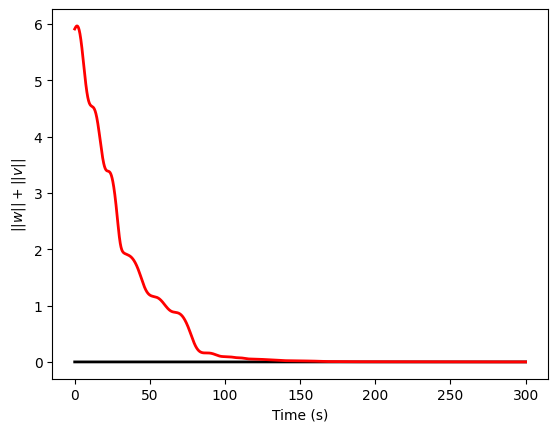

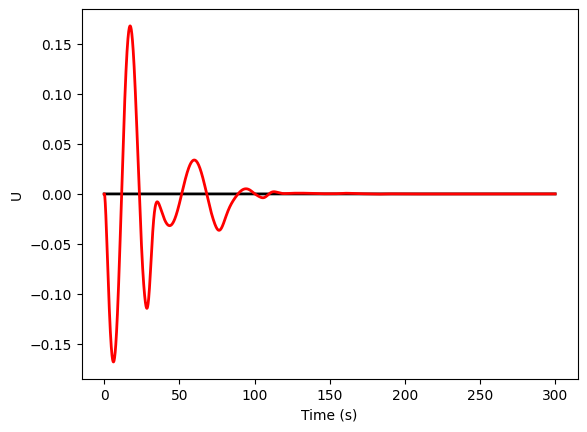

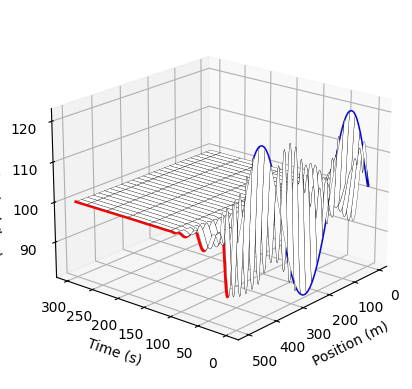

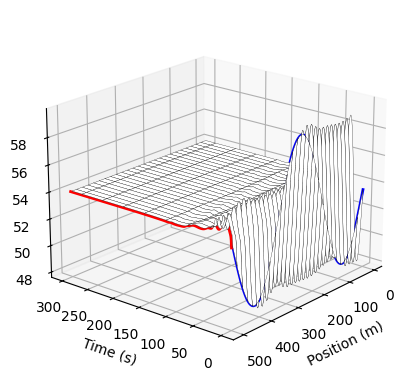

In [19]:
Name = 'PINNmu2K'
# Norm
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, uv_sf_norm, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, uv_sf_norm_test, sys.style3, color=sys.RGB_color2, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel(r'$||w||+||v||$')
# plt.savefig('../image/'+Name+'_w_v.pdf', dpi = 300)
plt.show()
# fig.savefig('uv_sf_norm_no',format='png')

# Actuation
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.savefig('../image/'+Name+'_U.pdf', dpi = 300)
plt.xlabel('Time (s)')
plt.ylabel('U')
plt.show()
# fig.savefig('U_sf_no',format='png')
# np.save('../image/'+Name+'_w_v_U_data.py', [uv_sf_norm, U_sf])

# Density evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, rho, cmap='turbo')
ax.plot_surface(X_arr, T_arr, rho, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), rho[0, :], color='blue', linewidth=2)
ax.plot([L]*len(t_log), t_log, rho[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density (veh/km)')
ax.view_init(elev=20, azim=-140)
ax.invert_xaxis()
# plt.savefig('../image/'+Name+'_Density.pdf', dpi = 300)
plt.show()
# fig.savefig('density_no',format='png')

# Velocity evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, v, cmap='turbo')
ax.plot_surface(X_arr, T_arr, v, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), v[0, :], color='blue', linewidth=2)
ax.plot([L]*len(t_log), t_log, v[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Velocity (km/h)')
ax.invert_xaxis()
ax.view_init(elev=20, azim=-140)
# plt.savefig('../image/'+Name+'_Velocity.pdf', dpi = 300)
plt.show()
# fig.savefig('velocity_no',format='png')


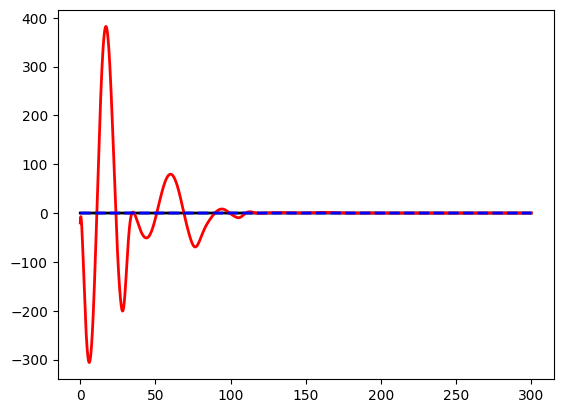

In [30]:
U_sf_test = U_sf*np.exp(-sys.L/(sys.tau*sys.vs)) +sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*(v[:,-1]/3.6-sys.vs)
U_sf_test = U_sf_test*3600
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf_test, sys.style3, color=sys.RGB_color1, linewidth=2)
plt.plot(t_log, U_sf, sys.style1, color=sys.RGB_color2, linewidth=2)